# HW4_ADM Group 8

In [3]:
Image("i.jpg",width=300, height=300)

In [2]:
import requests
import pandas as pd
import time
from functools import reduce
import numpy as np
import time
from bs4 import BeautifulSoup
import requests
import nltk 
#cleaning function
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
import string
from nltk.tokenize import RegexpTokenizer
#clustering function
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
#import funtions
from IPython.display import Image
from IPython.core.display import HTML 
from importlib import reload

## Extracting data

#### in the following function we extract data from 600 pages, in order to that in the first step the links of each announcement is extracted, then links are appended to a variable. Then for each extracted link the requested data is extracted for each announcement.

In [8]:
def extractring_page(url):
    try:
        l=[]
        soup=BeautifulSoup(requests.get(url).text, "html.parser")
        time.sleep(2)
        try:
            y=soup.findAll('p',{'titolo text-primary'})# extract the content of the tag which contains the links
            for house in y:
                # extracting the links, some links are not started with s string,therefore we they don't work
                s='https://www.immobiliare.it'
                s1=house.contents[1]['href'] 
                if s1.startswith("https")==False:
                    s1=s+s1# s is added to the incomplete links.
                l.append(s1)
        except:
            pass
    except:
        l=['The page does not exit']
    return(l)

In [ ]:
link=[]
for i in range(600):
    url = 'https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag='+str(i+1)
    link.append(extractring_page(url))
# the link contains list of list of the links, then the list of list with following code is convereted to one list.
link=reduce(lambda x,y: x+y,link)

In [ ]:
# the links are saved in the dataframe
link1=pd.DataFrame()
link1['links']=link
link.to_csv("Scrappinglink.csv")

In [4]:
# reading the links
l=pd.read_csv("Scrappinglink.csv")
l=list(l['links'])

In [7]:
# the first 5 links are shown below
l[:5]

['https://www.immobiliare.it/nuove_costruzioni/Roma/142255-immobile.html',
 'https://www.immobiliare.it/53131931-Vendita-Bilocale-viale-Italo-Calvino-Roma.html',
 'https://www.immobiliare.it/69090654-Vendita-Bilocale-via-Ezio-Sciamanna-12-Roma.html',
 'https://www.immobiliare.it/68902925-Vendita-Attico-Mansarda-via-Taranto-100-Roma.html',
 'https://www.immobiliare.it/70114842-Vendita-Attico-Mansarda-via-Degli-Orti-Di-Galba-Roma.html']

### Extracting Function

#### In the following function the required information for each announcent is extracted from Scrappinglink file that contains the links.

In [ ]:
def Objective_page(url):
    try:
        tag=BeautifulSoup(requests.get(url).text, "html.parser")
        time.sleep(2)
        l1=['piano','bagni','superficie','locali']
        df=[]
        # the tag that contains the information of the house such as locali...
        x=tag.findAll('div',{'class':'im-property__features'})
        y=tag.findAll('div',{'class':'clearfix description'}) #the tag that contains the description 
        d={}
        # the texts of the tag is extracted and with stripped_strings  attribute the white spaces of the string is removed
        house=[text for text in x[0].stripped_strings]
        house.reverse()# we reverse the list of our text that makes the extractions easier
        house1=[text for text in y[0].stripped_strings]
        house1=" ".join(house1)
        #Below the superfice, bagni, locali and price is extracted based on their position in the list.
        for i in l1:
            if i in house:
                index=house.index(i)
                if i=='superficie':
                    d[i]=house[index+3]
                else:
                    d[i]=house[index+1]
                if house[-1].find('€')!=-1:
                    d['prezzo(€)']=house[-1]
        d['description']=house1
    except:
        d['description']="there was a problem in this link"
    del tag
    return(d)

### Extracting the informations and description

#### multiprocessing is a package that supports spawning processes using an API similar to the threading module. The data is extarcted with this library faster. multiprocessing module provides support for parallelism based multiprocessing in Python. The pool is used to map the output data to the record, record list of our dictionaries, each dictionary contains the information for each announcement.



In [ ]:
from multiprocessing import Pool
with Pool(5) as p:
    records = p.map(Objective_page, l)
p.terminate()
p.join()

#### As the links were too much we split the data in our computers each of us extracted some links. At the end we had three dataset below I just show one of them , in the next step the rest are used.

In [ ]:
df1=pd.DataFrame.from_dict(records)
df2.to_csv("Scraping1.csv")

In [11]:
dfl=pd.read_csv("first-Scraping.csv")

In [12]:
dfl.head()

,Unnamed: 0,bagni,description,locali,piano,prezzo(€),superficie
0,0,NaN,Vendesi Appartamenti - Talenti Rione Rinascime...,1 - 5,NaN,€ 192.000 - € 705.000,46.0
1,1,1,papillo eur PAPILLO EUR in elegante complesso ...,2,1,€ 225.000,50.0
2,2,1,VENDITA BILOCALE TORREVECCHIA Rif: 18083 - TOR...,2,R,€ 159.000,65.0
3,3,1,"San Giovanni San Giovanni, Attico in Vendita, ...",2,A,€ 459.000,85.0
4,4,2,ATTICO CON TERRAZZO VILLA PAMPHILI Nel quartie...,5,A,€ 850.000,175.0


## Cleaning data


All the data frame was preprocessed by

1) Removing stop words and NA values

2) Removing punctuation

3) Stemming

4) Tokenization

To make our computational steps faster we applied the preprocessing only to description and title columns


##### in this step we concat the datasets for preprocessing and cleaning phase

In [144]:
df1=pd.read_csv('first-Scraping.csv')
df2=pd.read_csv('2rd_scaping_1.csv')
df3=pd.read_csv('3rd_scaping_1.csv')

In [145]:
finaldf = pd.concat([df1,df2,df3])
finaldf=finaldf.reset_index(drop=True)
finaldf.drop(['Unnamed: 0'], axis=1)# the Unnamed column is dropped

,bagni,description,locali,piano,prezzo(€),superficie
0,NaN,Vendesi Appartamenti - Talenti Rione Rinascime...,1 - 5,NaN,€ 192.000 - € 705.000,46.0
1,1,papillo eur PAPILLO EUR in elegante complesso ...,2,1,€ 225.000,50.0
2,1,VENDITA BILOCALE TORREVECCHIA Rif: 18083 - TOR...,2,R,€ 159.000,65.0
3,1,"San Giovanni San Giovanni, Attico in Vendita, ...",2,A,€ 459.000,85.0
4,2,ATTICO CON TERRAZZO VILLA PAMPHILI Nel quartie...,5,A,€ 850.000,175.0
5,3+,Gregorio Settimo - San Damaso Gregorio Settimo...,5+,3,€ 1.100.000,225.0
6,1,VENDITA TRILOCALE RISTRUTTURATO CASILINA Rif: ...,3,2,€ 119.000,85.0
7,1,VENDITA TRILOCALE CENTOCELLE Rif: 18067 - CENT...,3,1,€ 149.000,75.0
8,3+,Elegante villa stile Liberty a San Giovanni A ...,5+,NaN,€ 2.500.000,625.0
9,2,PRATI- DELLE VITTORIE PIAZZALE CLODIO Siamo a ...,4,9,€ 1.300.000,115.0


#### First we drop the NA values and then we split the data into information and description. 

In [146]:
df=finaldf.dropna()
informationdf=df[['bagni','locali','piano','prezzo(€)','superficie']]
descriptiondf=df[['description']]
descriptiondf=descriptiondf.reset_index(drop=True)
# we save the data before preprocessing for using in world cloud part
descriptiondf.to_csv("wordcloud.csv",index=False)

### Cleaning Information 

#### In this part we cleaned the columns which are for information dataset.
All the information data frame was cleaned by:

1) Removing euro (€) symbol and the white space

2) Replacing + symbol with a float number (3.5) and than deleting whte space

3) Replacing A,R,T,S symbolS with the following  float numbers (11.5, 0.3, 0.5, 0) and replacing 11+ with 11

4) Replacing 5+ with a float number 5.5

Morover before cleaning and replacing we have decided to drop all the NA and then to consider only the values greater than 10.000 €.

In [147]:
finaldf=finaldf.dropna()
# the € sign and da in removed
finaldf = finaldf.replace({r'\s+€':'', r'^\s+':''}, regex=True).replace(r'\€','', regex=True).replace(r'da','', regex=True)
# the . in price is removed that enable us to convert it to number
finaldf['prezzo(€)']=finaldf['prezzo(€)'].replace(r'\.',  '', regex=True)
# 0.5 is used to replace with + in number.
finaldf['bagni']=finaldf['bagni'].replace(r'3\+',  '3.5', regex=True).replace(r'\+', '', regex=True)
# the non number values are replaced with numbers 
finaldf['piano'] = finaldf['piano'].replace(r'A',  '11.5', regex=True).replace(r'11\+',  '11', regex=True).replace(r'R',  '0.3', regex=True).replace(r'T',  '0.5', regex=True).replace(r'S',  '0', regex=True)
finaldf['locali'] = finaldf['locali'].replace(r'5\+',  '5.5', regex=True)
finaldf[['bagni','locali','piano','prezzo(€)','superficie']] = finaldf[['bagni','locali','piano','prezzo(€)','superficie']].apply(pd.to_numeric)

In [8]:
# the announcement that has less than 10000 price are removed
finaldf[finaldf['prezzo(€)']>10000]

,Unnamed: 0,bagni,description,locali,piano,prezzo(€),superficie
1,1,1.0,papillo eur PAPILLO EUR in elegante complesso ...,2.0,1.0,225000,50.0
2,2,1.0,VENDITA BILOCALE TORREVECCHIA Rif: 18083 - TOR...,2.0,0.3,159000,65.0
3,3,1.0,"San Giovanni San Giovanni, Attico in Vendita, ...",2.0,11.5,459000,85.0
4,4,2.0,ATTICO CON TERRAZZO VILLA PAMPHILI Nel quartie...,5.0,11.5,850000,175.0
5,5,3.5,Gregorio Settimo - San Damaso Gregorio Settimo...,5.5,3.0,1100000,225.0
6,6,1.0,VENDITA TRILOCALE RISTRUTTURATO CASILINA Rif: ...,3.0,2.0,119000,85.0
7,7,1.0,VENDITA TRILOCALE CENTOCELLE Rif: 18067 - CENT...,3.0,1.0,149000,75.0
9,9,2.0,PRATI- DELLE VITTORIE PIAZZALE CLODIO Siamo a ...,4.0,9.0,1300000,115.0
10,10,1.0,VENDITA BILOCALE TORRE MAURA Rif: 18028 - TORR...,2.0,3.0,115000,58.0
11,11,3.0,Elegante appartamento zona Monteverde Nel quar...,5.5,3.0,695000,250.0


In [9]:
#the information and description datasets are seprated
informationdf=finaldf[['bagni','locali','piano','prezzo(€)','superficie']]
df=finaldf[['description']]

In [74]:
df

,description
1,papill eur papill eur eleg compless residenzia...
2,vend bilocal torrevecc rif torrevecc via ezi s...
3,san giovann san giovann attic vend via tarant ...
4,attic terrazz vill pamphil quart monteverd poc...
5,gregor settim san dam gregor settim san dam im...
6,vend trilocal ristruttur casilin rif casilin v...
7,vend trilocal centocell rif centocell via palm...
9,prat vittor piazzal clod proporv splendid atti...
10,vend bilocal torr maur rif torr maur via silic...
11,eleg appart zon monteverd quart monteverd nuov...


### Preprocessing the description dataset

In [45]:
# function for removing the accents
import unicodedata
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

In [46]:
#function for removing the punctuation
o=string.punctuation+'“–”’'
def remove_punctuations(text):
    for punctuation in o:
        text = text.replace(punctuation, '')
    return text

#### preprocessing phase

In [19]:
from textblob import Word
from nltk.stem.snowball import SnowballStemmer
stop = stopwords.words('italian')
stop1 = stopwords.words('english')
stemmer = SnowballStemmer("italian")
#okenizer = RegexpTokenizer(r'\w+')
rem=string.punctuation+'“–”’°‘'
pattern = r"[{}]".format(rem)
df['description']=df['description'].str.replace(pattern,' ')
df['description'] = df['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#removing italian and English stopwords
df['description'] = df['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['description']=df['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop1))
df['description'] = df['description'].str.replace('\d+','')
#tokinazation 
df["description"] = df["description"].apply(nltk.word_tokenize)
df['description']=df['description'].apply(lambda x :" ".join(x))
# stemming italian words to the italian root with stemmer function
df['description']=df['description'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
# lemmatization 
df['description'] = df['description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
#removing punctuation
df['description'] = df['description'].apply(remove_punctuations)
#removing accents
df['description'] = df['description'].apply(remove_accents)
# after stemming we found some stop words and then we remove them
df['description']=df['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

/home/atefe/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/atefe/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/atefe/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

NameError: name 'unicodedata' is not defined

#### Calulating the Tf-Idf
#### Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

In [ ]:
# The unique words are assinged to the dataframe tf 
words=list(df['description'].str.split(' ', expand=True).stack().unique())
tf=pd.DataFrame(words,columns=['words'])

In [ ]:
# for each word in dataframe the idf is calculated
for i,word in enumerate(tf['words']):
    tf.loc[i, 'idf'] = np.log(df.shape[0]/(len(df[df['description'].str.contains(word)])))

In [ ]:
#removing values with low or high idf
tf.sort_values(by=['idf'],ascending=False)
tf=tf.loc[(tf.idf<9) & (tf.idf>0.189)]
tf.to_csv('wordidf.csv')

In [ ]:
#reading the tf dataset
tf=pd.read_csv('wordidf.csv')
wordtf=list(tf['words'])
#assign the word as an index of dataframe that accelerate the retriving the idf of each term
tf.set_index('words',inplace=True)

In [ ]:
# create the new dataframe for creating the description dataset. all the unique words are the columns 
#of the description dataset
df1=pd.DataFrame(columns=wordtf)

In [ ]:
# creating the description dataset
for i in range(0,(len(df['description']))):
    for word in df.loc[i,'description'].split():
        if word in list(tf.index):
            termf=df.loc[i,'description'].split().count(word)
            termf=termf/len(df.loc[i,'description'].split())
            df1.loc[i,word]=termf*tf.loc[word]['idf']

In [ ]:
df1.to_csv("description3.csv")

In [18]:
df1.head()

,papill,eur,eleg,compless,residenzial,rifinitissim,bilocal,compost,soggiorn,angol,...,itern,ondegg,artig,rds,ccin,stan,ponen,eleonor,gur,recentem
0,0.141762,0.044818,0.030005,0.027901,0.025666,0.060168,0.029249,0.004148,0.011902,0.019886,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.042187,0.002992,NaN,0.014341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002881,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.044125,NaN,NaN,NaN,NaN,0.006100,NaN,0.029244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ____Clustering____

#### K-mean clustering and Elbow method
#### K-means is a simple unsupervised machine learning algorithm that groups a dataset into a user-specified number (k) of clusters. As we don't know the right number of k the elbow method is used. The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k, and for each value of k calculate the sum of squared errors (SSE).Then, plot a line chart of the SSE for each value of k. If the line chart looks like an arm, then the "elbow" on the arm is the  value of k that is the best. The idea is that we want a small SSE, but that the SSE tends to decrease toward 0 as we increase k(the SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster). So our goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.

In [3]:
dfk=pd.read_csv("description3.csv")
dfk=dfk.drop(['Unnamed: 0'], axis=1)
dfk=dfk.fillna(0)
dfk=dfk.as_matrix()

In [7]:
cus = list()
n_cluster = range(2,15)
for n in n_cluster:
    kmeans = KMeans(init="k-means++",n_clusters=n)
    kmeans.fit(dfk)
    cus.append(np.average(np.min(cdist(dfk, kmeans.cluster_centers_, 'euclidean'), axis=1)))

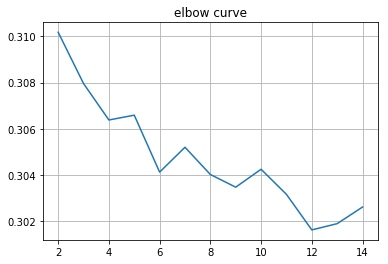

In [8]:
plt.plot(n_cluster, cus)
plt.title('elbow curve')
plt.grid(True)
plt.show()

In [29]:
kmeans = KMeans(init="k-means++",n_clusters=6, random_state=0).fit(dfk)
# l is a tuple the first index of l the announcment and the second index is the cluster number
l=[]
for i in range(len( kmeans.labels_)):
    l.append((i,kmeans.labels_[i]))

In [30]:
matrix=pd.read_csv("information1.csv")
matrix=matrix.drop(['Unnamed: 0'], axis=1)
matrix=matrix.as_matrix()

In [31]:
cus2 = list()
n_cluster = range(2,15)
for n in n_cluster:
    km = KMeans(init="k-means++",n_clusters=n)
    km.fit(matrix)
    cus2.append(np.average(np.min(cdist(matrix, km.cluster_centers_, 'euclidean'), axis=1)))

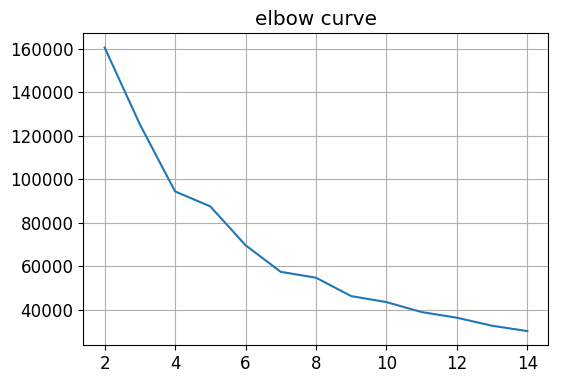

In [52]:
plt.plot(n_cluster, cus2)
plt.title('elbow curve')
plt.grid(True)
plt.show()

In [33]:
km = KMeans(init="k-means++",n_clusters=7, random_state=0).fit(matrix)
l1=list()
for i in range(len( km.labels_)):
    l1.append((i,km.labels_[i]))

In [34]:
l=set(l)
l1=set(l1)

### Jaccard similarity


#### The Jaccard index, also known as Intersection over Union and the Jaccard similarity coefficient , is a statistic used for comparing the similarity and diversity of our different clusters. The Jaccard coefficient measures similarity between finitet sets, and is defined as the size of the intersection divided by the size of the union of the sample sets.

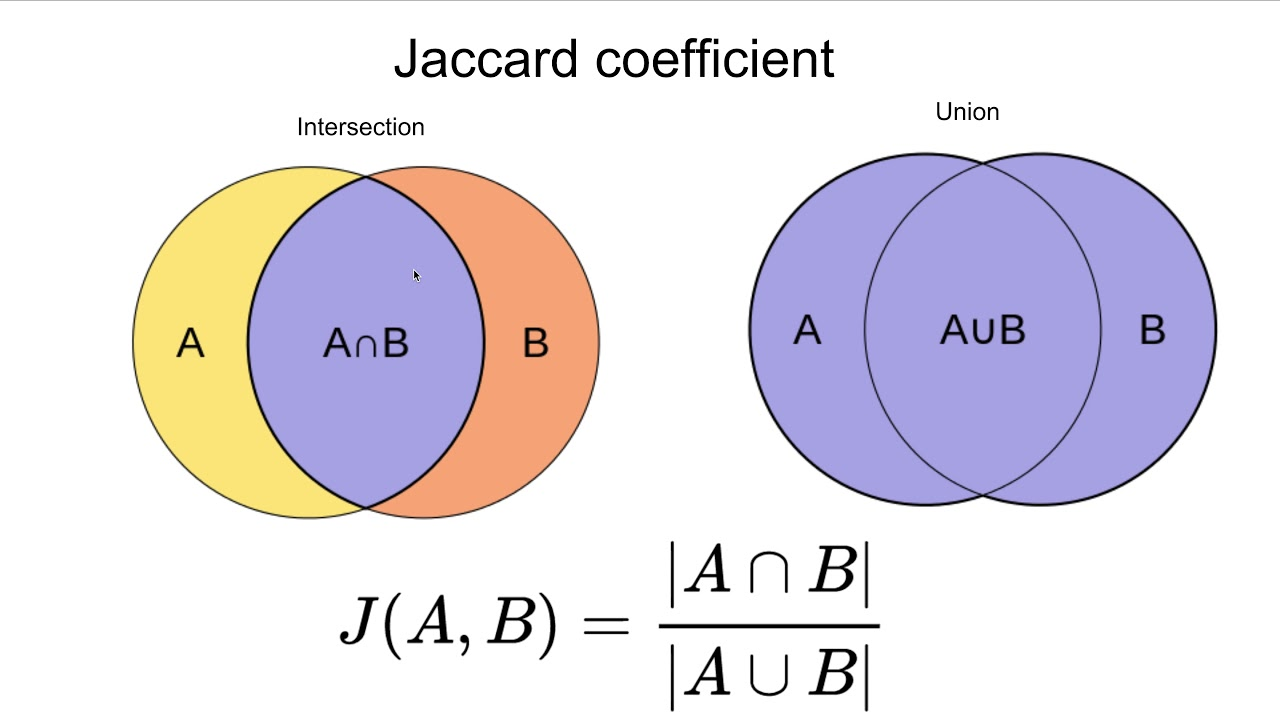

In [29]:
from IPython.display import Image
from IPython.core.display import HTML 
Image("j.jpg",width=300, height=300)

In [35]:
def jaccard_similarity(a, b):
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [36]:
from operator import itemgetter
def jaccard_calculation(l,l1):
    dictS={}
    for i in range(6):
        jaccard=[]
        for k in l:
            if k[1]==i:
                jaccard.append(k[0])
        for j in range(7):
            jaccard1=[]
            for k1 in l1:
                if k1[1]==j:
                    jaccard1.append(k1[0])
            dictS[(i,j)]=jaccard_similarity(set(jaccard),set(jaccard1))
    dictS1=sorted(dictS.items(), key=itemgetter(1))
    return(dictS1)

In [37]:
d=jaccard_calculation(l,l1)

In [38]:
d

[((0, 1), 0.0),
 ((0, 2), 0.0),
 ((0, 3), 0.0),
 ((0, 5), 0.0),
 ((1, 1), 0.0),
 ((1, 5), 0.0),
 ((2, 1), 0.0),
 ((2, 5), 0.0),
 ((4, 1), 0.0),
 ((4, 5), 0.0),
 ((5, 1), 0.0),
 ((5, 5), 0.0),
 ((1, 0), 0.0018285249898415277),
 ((3, 5), 0.002320634306710501),
 ((0, 4), 0.003203661327231121),
 ((2, 0), 0.0034122842232035327),
 ((1, 3), 0.00392156862745098),
 ((5, 4), 0.0044822949350067235),
 ((2, 3), 0.005199306759098787),
 ((5, 3), 0.006578947368421052),
 ((5, 6), 0.008744977546679272),
 ((4, 3), 0.008905852417302799),
 ((5, 2), 0.009),
 ((1, 6), 0.009934577174703174),
 ((3, 1), 0.01063624057242313),
 ((0, 0), 0.015077424612876936),
 ((4, 2), 0.015881147540983607),
 ((2, 2), 0.01664932362122789),
 ((1, 2), 0.016778523489932886),
 ((0, 6), 0.020808129687878055),
 ((2, 4), 0.022685185185185187),
 ((1, 4), 0.023422562141491396),
 ((2, 6), 0.023930384336475707),
 ((5, 0), 0.032),
 ((4, 4), 0.034427284427284426),
 ((3, 3), 0.03598649300530632),
 ((4, 6), 0.05345659163987138),
 ((3, 2), 0.069

#### The first index is the description cluster number and the second index is for information
(3, 4), 0.1706739871260886)
(3, 6), 0.3240732223346518)
(3, 0), 0.33306948109058926)
    

In [39]:
tuplew=[(3, 4),(3, 6),(3, 0)]

## Word cloud of house descriptions
#### Word clouds (also known as text clouds or tag clouds) work in a simple way: the more a specific word appears in a source of textual data (such as a speech, blog post, or database), the bigger and bolder it appears in the word cloud. Of course we have 3 differents word clouds, one for each value of our Jakkard similarity(the 3 highest values).

In [40]:
from os import path
from PIL import Image
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np

In [41]:
dfc=pd.read_csv("wordcloud.csv")
dfc1=pd.read_csv("information1.csv")

##### All the preprocessing phases are implemented again except stemming because it convert the words to their roots


In [47]:
from textblob import Word
stop = stopwords.words('italian')
stop1 = stopwords.words('english')
rem=string.punctuation+'“–”’°‘'
pattern = r"[{}]".format(rem)
dfc['description']=dfc['description'].str.replace(pattern,' ')
dfc['description'] = dfc['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
dfc['description'] = dfc['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
dfc['description']=dfc['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop1))
dfc['description'] = dfc['description'].str.replace('\d+','')
dfc["description"] = dfc["description"].apply(nltk.word_tokenize)
dfc['description']=dfc['description'].apply(lambda x :" ".join(x))
dfc['description'] = dfc['description'].apply(remove_punctuations)
dfc['description'] = dfc['description'].apply(remove_accents)
dfc['description']=dfc['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [48]:
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS
def wordcloudf(wc):
    mpl.rcParams['font.size']=12                #10 
    mpl.rcParams['savefig.dpi']=100             #72 
    mpl.rcParams['figure.subplot.bottom']=.1 


    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
                              background_color='white',
                              stopwords=stopwords,
                              max_words=200,
                              max_font_size=40, 
                              random_state=42
                             ).generate(wc)

    print(wordcloud)
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [49]:
def drwingclodplot(tuplew):
    for w in tuplew:
        wordc=[]
        for m in l:
            if m[1]==w[0]:
                wordc.append(m[0])
        wordc1=[]
        for m1 in l1:
            if m1[1]==w[1]:
                wordc1.append(m1[0])
        worddoc=list(set().union(wordc,wordc1))
        wc=str(dfc.loc[worddoc])
        wordcloudf(wc)

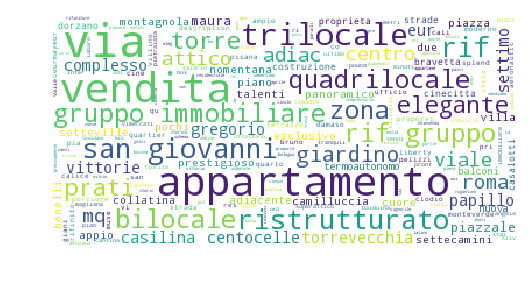

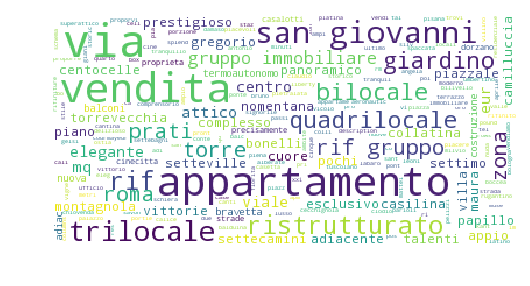

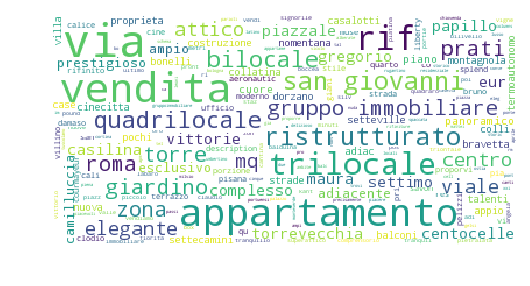

In [50]:
drwingclodplot(tuplew)